### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [5]:
def show_dst(train_df, column):
    plt.figure(figsize = (16, 8))

    train_df[column].hist(bins=18)
    plt.ylabel('Count')
    plt.xlabel(column)

    plt.title('Target distribution')
    plt.show()
    return None

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'Natalia_Ramazanova_predictions.csv '

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Обзор обучающего датасета

In [8]:
print(train_df.shape)
train_df.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [10]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [11]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


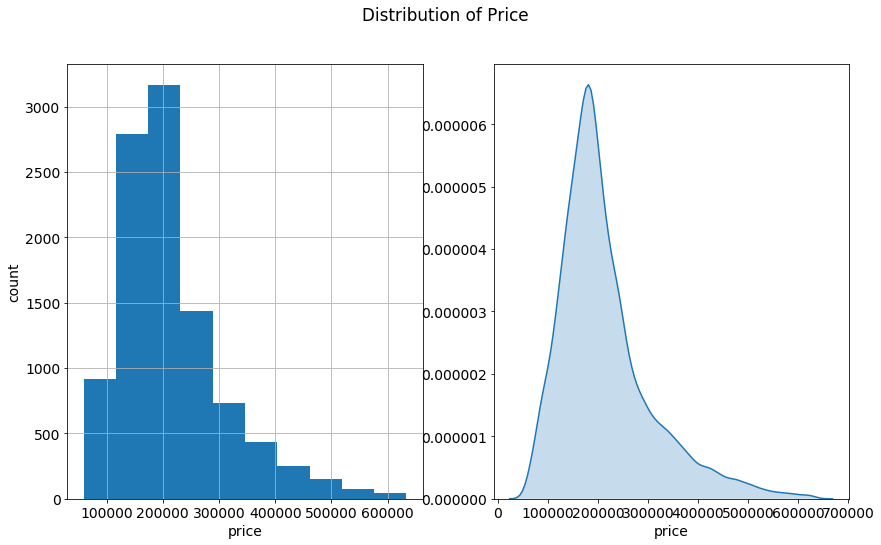

In [12]:
plt.figure(figsize = (14, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Distribution of Price')
plt.show()

### Подготовка обучающего датасета

Считаем что площадь(Square)  не может быть меньше 12м2. Выбирам данные:

In [13]:
train_df[(train_df["Square"]) < 12]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


Меняем данные на медиану

In [14]:
train_df.loc[(train_df["Square"] < 12), "Square"] = train_df["Square"].median() 

Выбирам наибольшую площадь кухни(KitchenSquare):

In [15]:
train_df.nlargest(10, "KitchenSquare")

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
6240,4966,96,3.0,78.445675,47.146757,75.0,9,12.0,1977,0.041116,B,B,53,14892,4,NaN,1,4,B,290354.484070
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165


Считаем. что при площади (Square) меньше 100, площадь кухни (KitchenSquare) не может быть больше 35. Выбираем данные и меняем их на медиану:

In [16]:
train_df[(train_df["KitchenSquare"] >= 35) & (train_df["Square"] <= 100)].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1077,9690,27,1.0,40.081042,37.834964,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
3379,16781,27,1.0,36.138409,36.710539,36.0,19,19.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,131742.536281
4079,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019,0.034656,B,B,0,168,0,NaN,0,0,B,193130.585871


In [17]:
Kit_med = train_df['KitchenSquare'].median()

In [18]:
train_df.loc[(train_df["KitchenSquare"] >= 35) & (train_df["Square"] <= 100), "KitchenSquare"] = Kit_med

Выбирам наменьшую площадь кухни(KitchenSquare):

In [19]:
train_df.nsmallest(10, "KitchenSquare")

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
42,9833,1,2.0,56.494318,54.723569,0.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,196078.907289
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
65,11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,114063.092041
70,10362,27,2.0,79.227049,NaN,0.0,9,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,167023.973143


Считаем. что при площади (Square) больше 60, площадь кухни (KitchenSquare) не может быть меньше 3. Выбираем данные и меняем их на медиану:

In [20]:
train_df[(train_df["KitchenSquare"] <= 3) & (train_df["Square"] >= 60)].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.827069
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
27,7550,23,2.0,64.556209,NaN,1.0,8,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,173910.923723
32,13253,27,2.0,63.679116,37.275775,1.0,9,15.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,178721.706337
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070


In [21]:
train_df.loc[(train_df["KitchenSquare"] <= 3) & (train_df["Square"] >= 60), "KitchenSquare"] = Kit_med

In [22]:
train_df.loc[(train_df["KitchenSquare"] <= 2), "KitchenSquare"] = Kit_med

Считаем, что жилая площадь не может быть больше общей площади. Выбираем данны:

In [23]:
train_df[train_df['Square'] < train_df['LifeSquare']].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,6.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,6.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,6.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,6.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,6.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
178,2416,57,1.0,29.298168,29.770784,5.0,7,5.0,1964,0.133215,B,B,49,11395,3,1406.0,3,4,A,148991.265200
184,3398,74,1.0,48.743665,51.011232,6.0,12,20.0,2017,0.075779,B,B,6,1437,3,NaN,0,2,B,165071.825722
212,1748,88,2.0,52.513310,67.628717,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
217,5540,27,3.0,57.643613,59.425078,9.0,16,10.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,198351.892455
234,12633,27,3.0,81.867166,81.884548,6.0,12,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,182228.520030


Заполняем пропущенные данные жилой площади (LifeSquare) и заменяем значения, где жилая площадь (LifeSquare) больше общей площади (Square). Будме считать, что жилая площадь (LifeSquare) не меньше 65% от общей площади (Square)

In [24]:
def fill_LifeSquare(train_df):
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'Square'])/100*65
    return train_df

In [25]:
fill_LifeSquare(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,31.160355,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Считаем что жилая площадь(LifeSquare)  не может быть меньше 12м2. Выбирам данные:

In [26]:
train_df[(train_df["LifeSquare"]) < 12].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,6.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
95,4280,34,2.0,61.334968,4.091945,6.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
134,12613,6,2.0,65.496674,5.589324,6.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27,3.0,51.991064,4.896202,6.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
160,3522,6,1.0,66.419841,3.987101,6.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
270,15215,17,1.0,46.692974,5.941401,6.0,7,1.0,2015,0.000000,B,B,18,3374,5,620.0,1,2,B,212290.684086
279,8727,1,2.0,79.521221,4.634049,6.0,5,1.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B,232726.628137
363,15751,9,1.0,44.171793,1.251846,6.0,11,18.0,2017,0.161532,B,B,25,5648,1,30.0,2,4,B,134910.715588
475,6333,27,2.0,64.049695,4.008230,6.0,5,5.0,2017,0.017647,B,B,2,469,0,NaN,0,0,B,189477.560210
477,8849,45,1.0,63.419553,2.286357,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,325600.765809


Меняем найденные значения на значения по функции:

In [27]:
def fill_LifeSquare_1(train_df):
    train_df.loc[(train_df['LifeSquare'] < 12), 'LifeSquare'] = \
    (train_df.loc[(train_df['LifeSquare'] < 12), 'Square'])/100*65
    return train_df

In [28]:
fill_LifeSquare_1(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,31.160355,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Выбираем значения, где площадь кухни (KitchenSquare) приблизительно равна общей площади (Square) и меняем их:

In [29]:
train_df[train_df['Square'] - train_df['KitchenSquare'] <= 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
9895,2737,27,3.0,123.430072,80.229547,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047


In [30]:
def fill_KitchenSquare(train_df):
    train_df.loc[(train_df['Square'] - train_df['KitchenSquare'] <= 5), 'KitchenSquare'] = \
    (train_df.loc[(train_df['Square'] - train_df['KitchenSquare'] <= 5), 'Square'])/100*9
    return train_df

In [31]:
fill_KitchenSquare(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,31.160355,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Выбираем значения комнат (Rooms) больше 5 при площади (Square) меньше 100 м2 и меняем их на медиану:

In [32]:
train_df[(train_df['Rooms'] >= 5) & (train_df['Square'] <= 90)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
3271,6358,27,5.0,42.003293,27.302141,6.0,5,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,112693.641769
4431,7594,53,5.0,39.906082,39.394024,6.0,5,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,206148.845716
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
8925,4214,105,5.0,85.313605,56.686693,5.0,4,12.0,1967,0.040243,B,B,25,3478,11,2729.0,3,1,B,461678.738428


In [33]:
Rooms_med = train_df['Rooms'].median()

In [34]:
train_df.loc[(train_df['Rooms'] >= 5) & (train_df['Square'] <= 90), 'Rooms'] = Rooms_med

Выбираем нулевые занчения для комнат (Rooms) и меяем их значения в зависимости от площади (Square):

In [35]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,6.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,27.164073,6.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,32.164276,6.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,52.969440,6.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,52.513310,34.133651,6.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,6.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [36]:
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] <= 90), 'Rooms'] = Rooms_med

In [37]:
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 90), 'Rooms'] = 3

выбираем наибольшие значения площади (Square) и меняем их на медиану:

In [38]:
train_df.nlargest(10, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
4262,28,9,2.0,604.705972,393.058882,6.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,266.126368,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
1981,7917,27,3.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
9910,16568,27,4.0,200.334539,130.217451,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
8511,4249,23,5.0,198.930182,123.139863,10.0,1,2.0,2011,0.014073,B,B,2,475,0,NaN,0,0,B,345665.209100
652,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
7201,3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,B,B,24,5613,5,1340.0,2,5,B,423443.464367
5087,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253


In [39]:
Square_med = train_df['Square'].median()

In [40]:
train_df.loc[(train_df['Square'] > 400), 'Square'] = Square_med

выбираем наибольшие значения жилой площади (LifeSquare) и меняем их на медиану:

In [41]:
train_df.nlargest(10, 'LifeSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6977,11602,30,2.0,52.513580,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
4262,28,9,2.0,52.513580,393.058882,6.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,52.513580,266.126368,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
1981,7917,27,3.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2603,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663
4047,15362,23,1.0,163.286965,161.155275,6.0,4,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,228572.520347
5444,14181,62,3.0,156.636577,153.685835,6.0,1,3.0,2005,0.072158,B,B,2,629,1,NaN,0,0,A,502523.573863
1867,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
2708,12570,62,3.0,137.907783,136.697187,15.0,4,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,295412.633601


In [42]:
LifeSquare_med = train_df['LifeSquare'].median()

In [43]:
train_df.loc[(train_df['LifeSquare'] > 240), 'LifeSquare'] = LifeSquare_med

Выбираем значения, где разница между площадью (Square) жилой площадью минимальна (LifeSquare) и меняем их:

In [44]:
train_df[train_df['Square'] - train_df['LifeSquare'] <= 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
14,10953,27,1.0,53.769097,52.408027,6.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
42,9833,1,2.0,56.494318,54.723569,6.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,196078.907289
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,228584.001072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,3355,53,1.0,39.211416,36.159431,6.0,19,18.0,2019,0.049637,B,B,34,7759,0,229.0,1,3,B,180600.181118
9951,9237,25,1.0,33.516313,31.086243,6.0,13,11.0,2015,0.069753,B,B,53,13670,4,NaN,1,11,B,148066.435795
9964,10463,27,3.0,49.574590,45.590573,6.0,18,25.0,2013,0.072158,B,B,2,629,1,NaN,0,0,A,145025.095667
9974,2159,30,1.0,33.227093,32.639166,6.0,4,4.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,65949.315881


In [45]:
def fill_LifeSquare_3(train_df):
    train_df.loc[(train_df['Square'] - train_df['LifeSquare'] <= 5), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] - train_df['LifeSquare'] <= 5), 'Square'])/100*65
    return train_df

In [46]:
fill_LifeSquare_3(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,34.679438,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,31.160355,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Выбираем значения, года постройки дома (HouseYear) и меняем их:

In [47]:
train_df.nlargest(10, 'HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
585,15051,53,2.0,59.597891,44.869530,10.0,3,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,243114.222804
707,4345,62,1.0,49.275155,32.028851,6.0,5,1.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,135353.885620
790,6845,169,3.0,87.371123,64.905206,12.0,4,24.0,2020,0.178917,B,B,18,3594,4,192.0,1,5,B,295304.011974
918,2530,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,283334.496716
1499,6731,120,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,B,B,27,5664,48,2300.0,3,11,B,536020.260344
2493,3445,53,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,170847.416766
2877,8832,1,3.0,83.260743,54.119483,6.0,15,21.0,2020,0.007122,B,B,1,264,0,NaN,0,1,B,242243.090839
3357,9600,62,1.0,55.911215,43.821379,10.0,6,17.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,138770.715048


In [48]:
train_df.loc[(train_df['HouseYear'] == 4968), 'HouseYear'] = 1968

Выбираем наибольшие значения, кличества этажей дома (HouseFloor) и меняем их:

In [49]:
train_df.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8854,78,30,2.0,65.773749,42.752937,6.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
6131,10806,5,1.0,51.944587,33.763982,6.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
8599,9300,74,2.0,71.747869,46.636115,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.552655
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B,213171.135199
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002
359,15722,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,558262.139114
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732


In [50]:
HouseFloor_med = train_df['HouseFloor'].median()

In [51]:
train_df.loc[(train_df['HouseFloor'] > 50), 'HouseFloor'] = HouseFloor_med

Считаем, что количество этажей (HouseFloor) не может = 0. Выбираем значения и менем их:

In [52]:
train_df.nsmallest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,52.203402,6.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,77.289948,6.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,69.523266,6.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,39.327111,6.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,67.737407,6.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
65,11398,62,1.0,41.194188,26.776223,6.0,6,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,114063.092041
70,10362,27,2.0,79.227049,51.497582,6.0,9,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,167023.973143
195,4645,54,2.0,76.312851,49.603353,6.0,14,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,466730.805333
223,4622,27,2.0,62.153994,36.094352,6.0,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,194091.992560
252,8139,27,2.0,58.553809,38.059976,6.0,7,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,177511.314827


In [53]:
train_df.loc[(train_df['HouseFloor'] == 0), 'HouseFloor'] = train_df['HouseFloor'].median()

Удаляем признак Healthcare_1 т.к. по нему много проспусков

In [54]:
train_df["Healthcare_1"] = train_df["Healthcare_1"].fillna(0)

In [55]:
train_df.groupby(['DistrictId', 'Social_1', 'Social_2', 'Helthcare_2']).agg({'Healthcare_1':'median'})

Healthcare_1
DistrictId Social_1 Social_2 Helthcare_2              
0          25       4756     5                  2857.0
           30       5285     6                   645.0
1          1        264      0                     0.0
           3        760      0                     0.0
           6        1318     1                   200.0
...                                                ...
202        30       7538     5                  4702.0
205        19       3856     2                     0.0
207        16       3681     2                  1815.0
208        20       2738     1                     0.0
209        25       3478     3                  2729.0

[434 rows x 1 columns]

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [56]:
print(train_df['Ecology_2'].value_counts())
print(train_df['Ecology_3'].value_counts())
print(train_df['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [57]:
transform_d_train = pd.get_dummies(train_df)
transform_d_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'],
      dtype='object')

In [58]:
train_df = transform_d_train

для введения новых признаков вычислем стоимость квадратного метра площади (Square):

In [59]:
train_df['Price_m2'] = train_df['Price'] / train_df['Square']

Добавим дополнительный признак -  стоимость м2 (District_m2) в зависимости от раойна (DistrictId)

In [60]:
District_m2 = train_df.groupby(['DistrictId'], as_index=False).agg({'Price_m2':'median'})\
                    .rename(columns={'Price_m2':'District_m2'})

Добавим дополнительный признак - стоимость м2 (HouseYear_m2) в зависимости от года постройки дома (HouseYear)

In [61]:
HouseYear_m2 = train_df.groupby(['HouseYear'], as_index=False).agg({'Price_m2':'median'})\
                    .rename(columns={'Price_m2':'HouseYear_m2'})

Добавлем новые признаки в датасет:

In [62]:
train_df = train_df.merge(District_m2, on=['DistrictId'], how='left')
train_df = train_df.merge(HouseYear_m2, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price_m2,District_m2,HouseYear_m2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,0,1,0,1,0,1,3854.958571,4358.274853,4473.255408
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,0,1,0,1,0,1,4567.491245,4437.304072,4317.685445
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,220925.908524,0,1,0,1,0,1,4915.149522,4845.919064,4433.699994
3,5809,58,2.0,53.352981,34.679438,9.0,8,17.0,1977,0.437885,...,175616.227217,0,1,0,1,0,1,3291.591637,2949.975415,2901.326376
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,0,1,0,1,0,1,3788.892642,3992.031265,4367.263383


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
Pr

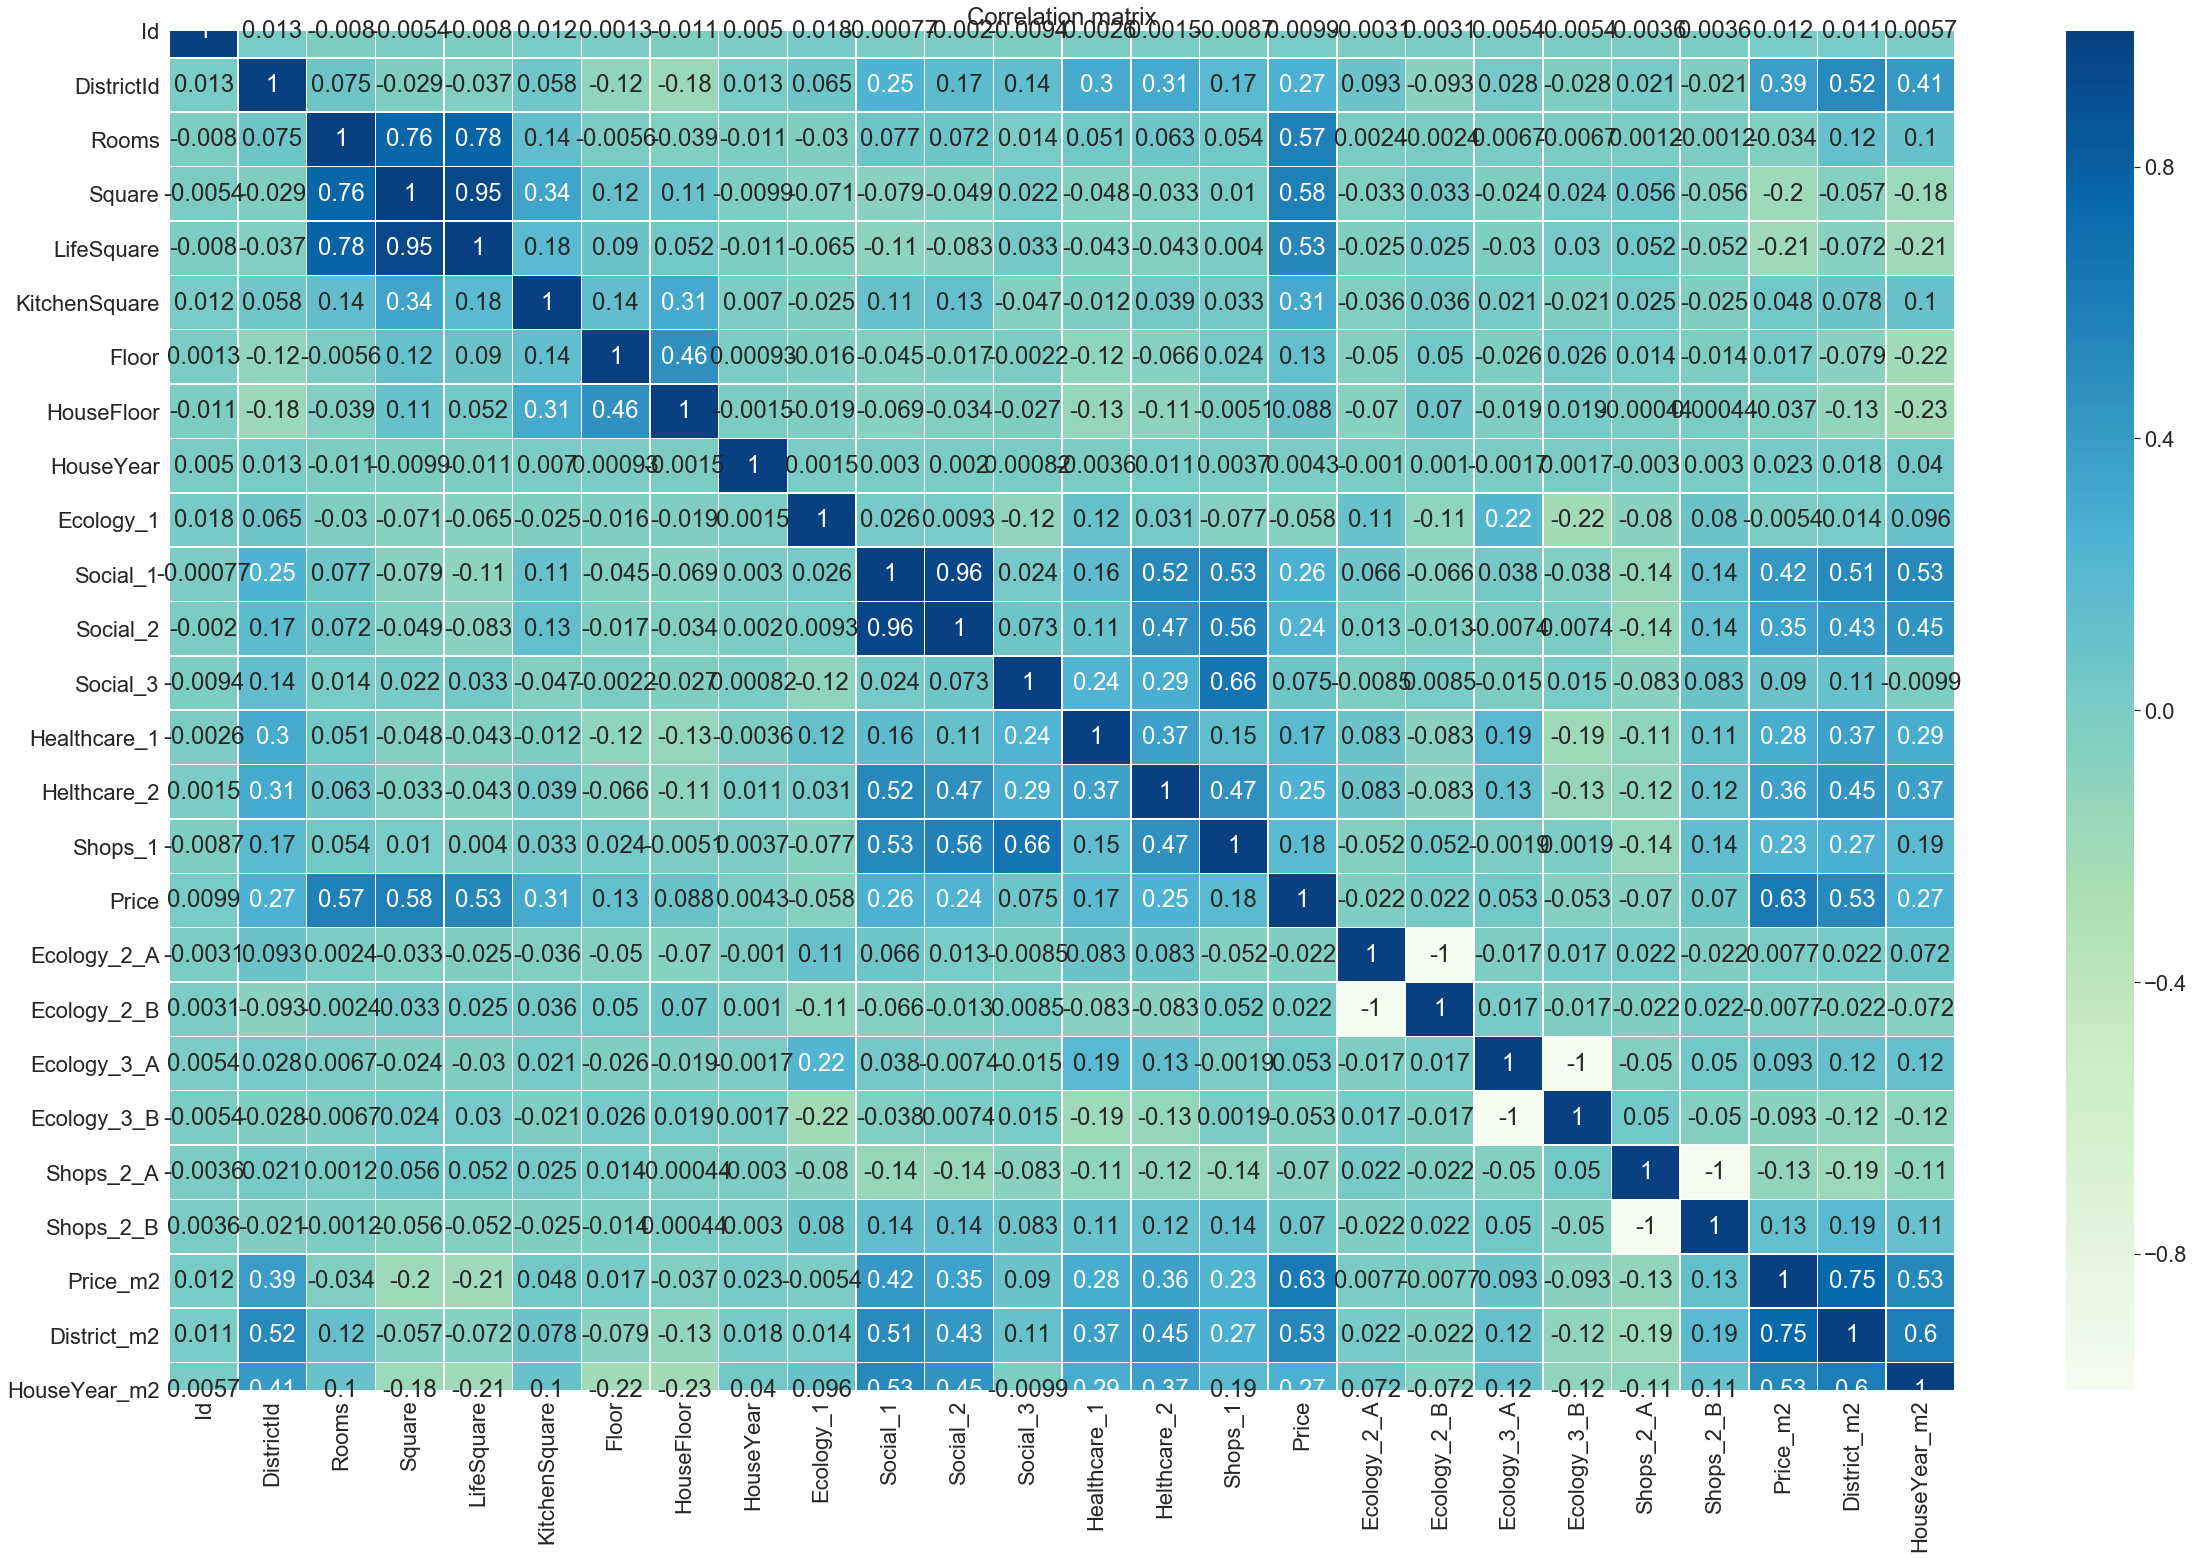

In [64]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Отбираем признаки для построения модели:

In [65]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B', 'Price_m2', 'District_m2', 'HouseYear_m2'],
      dtype='object')

In [66]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
       'District_m2', 'HouseYear_m2']
target_name = 'Price'

In [67]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,District_m2,HouseYear_m2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,0.0,0,11,4358.274853,4473.255408,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,4437.304072,4317.685445,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,4845.919064,4433.699994,220925.908524
3,2.0,53.352981,34.679438,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,2949.975415,2901.326376,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,3992.031265,4367.263383,150226.531644


Масштабируем признаки

In [68]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [69]:
stand_features

array([[ 0.13874895, -0.43242023, -0.42727429, ...,  1.40835595,
         0.43176354,  0.90729389],
       [ 1.37426941,  0.49621198,  0.38100456, ...,  2.44870045,
         0.51097891,  0.70352302],
       [ 0.13874895, -0.5915601 , -0.44595483, ..., -0.25619523,
         0.92055638,  0.85548285],
       ...,
       [-1.09677151, -0.43465254, -0.29638614, ..., -0.88040193,
        -1.17119181, -1.1810311 ],
       [ 0.13874895, -0.66213789, -0.09217552, ...,  0.15994256,
         0.33558678,  0.94291065],
       [-1.09677151, -0.92107082, -1.05861411, ...,  0.78414926,
         0.40710193,  0.73363935]])

In [70]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,District_m2,HouseYear_m2,Price
0,0.138749,-0.432420,-0.427274,-0.581834,-0.291306,-0.629946,-0.010080,-0.250529,0.474169,0.654880,-0.127533,-0.637872,-0.883480,1.408356,0.431764,0.907294,184966.930730
1,1.374269,0.496212,0.381005,0.270363,-0.291306,-0.629946,-0.010035,-0.998053,1.215681,1.237169,-0.295384,-0.380379,-0.213923,2.448700,0.510979,0.703523,300009.450063
2,0.138749,-0.591560,-0.445955,-0.581834,-0.100498,-0.149255,-0.010085,-0.581588,0.531208,0.600720,-0.337347,-0.392181,-0.213923,-0.256195,0.920556,0.855483,220925.908524
3,0.138749,-0.150641,-0.028218,0.696462,-0.100498,0.651898,-0.010040,2.680470,-0.096225,0.095553,-0.211458,0.525135,-0.883480,0.159943,-0.979853,-1.151673,175616.227217
4,-1.096772,-0.869527,-0.859090,-0.155735,0.471924,-0.149255,-0.010045,-0.894969,0.588247,0.105786,-0.295384,1.591583,0.455633,-0.048126,0.064657,0.768462,150226.531644


Разбиваем данные на на обучающую и валидационную выборку

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(df[feature_names], df[target_name], test_size=0.3, shuffle=True, random_state=42)

Обучаем модель:

In [72]:
model = RandomForestRegressor(max_depth=10, n_estimators=300, random_state=20)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

R2:	0.898


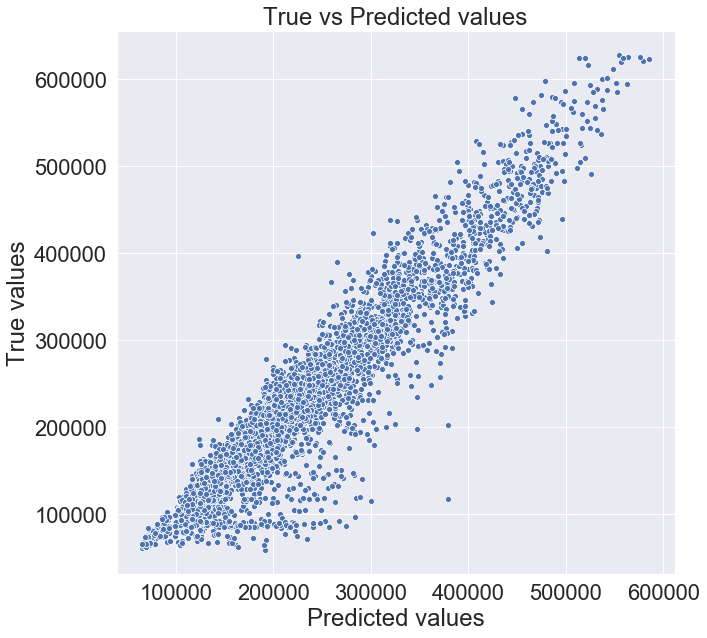

In [73]:
y_train_preds = model.predict(X_train)
evaluate_preds(y_train.values.flatten(), y_train_preds.flatten())

In [74]:
arr_r2_test = []
arr_r2_train = []

max_depth_ = [4,5,6,7,8,9,10,11]
for max_depth in max_depth_:
    model1 = RandomForestRegressor(max_depth=max_depth, n_estimators=60, random_state=20)
    model1.fit(X_train,y_train)
    ##model2 = Ridge()
    predict_price = model1.predict(X_valid)
    arr_r2_test.append(r2(y_valid.values.flatten(), predict_price))
    predict_price_train = model1.predict(X_train)
    arr_r2_train.append(r2(y_train.values.flatten(), predict_price_train))

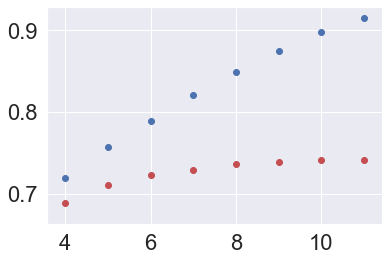

In [75]:
plt.scatter(max_depth_, arr_r2_test, c = 'r')
plt.scatter(max_depth_, arr_r2_train, c = 'b')

In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.447059
14,District_m2,0.362165
0,Rooms,0.027204
15,HouseYear_m2,0.026975
2,LifeSquare,0.025325
4,Floor,0.015230
9,Social_2,0.013142
6,HouseYear,0.012708
7,Ecology_1,0.012618
8,Social_1,0.011184


Проверяем на валидационной выборке:

R2:	0.74


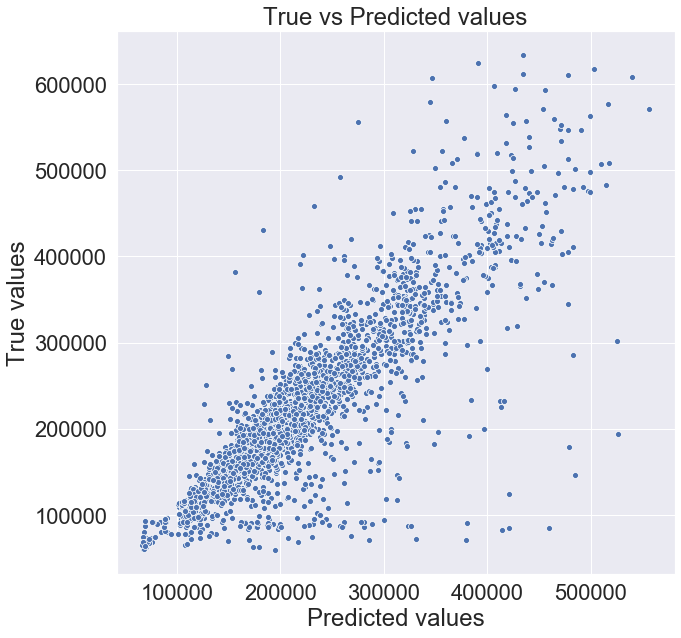

In [77]:
y_valid_preds = model.predict(X_valid)
evaluate_preds(y_valid.values.flatten(), y_valid_preds.flatten())

Обзор тестового датасета

In [78]:
test_df.shape

(5000, 19)

In [79]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [80]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Подготовка тестового датасета:

In [81]:
test_df.loc[(test_df["Square"] < 12), "Square"] = test_df["Square"].median() 

In [82]:
Kit_med_1 = test_df['KitchenSquare'].median()

In [83]:
test_df.loc[(test_df["KitchenSquare"] >= 35) & (test_df["Square"] <= 100), "KitchenSquare"] = Kit_med_1

In [84]:
test_df.loc[(test_df["KitchenSquare"] <= 3) & (test_df["Square"] >= 60), "KitchenSquare"] = Kit_med_1

In [85]:
test_df.loc[(test_df["KitchenSquare"] <= 2), "KitchenSquare"] = Kit_med_1

In [86]:
def fill_LifeSquare_test(test_df):
    test_df.loc[(test_df['Square'] < test_df['LifeSquare']) | (test_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (test_df.loc[(test_df['Square'] < test_df['LifeSquare']) | (test_df['LifeSquare'].isna()), 'Square'])/100*65
    return test_df

In [87]:
fill_LifeSquare_test(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,45.021069,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,8.838582,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,52.848394,6.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [88]:
def fill_LifeSquare_1_test(test_df):
    test_df.loc[(test_df['LifeSquare'] < 12), 'LifeSquare'] = \
    (test_df.loc[(test_df['LifeSquare'] < 12), 'Square'])/100*65
    return test_df

In [89]:
fill_LifeSquare_1_test(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,45.021069,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,8.838582,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,52.848394,6.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [90]:
def fill_KitchenSquare_test(test_df):
    test_df.loc[(test_df['Square'] - test_df['KitchenSquare'] <= 5), 'KitchenSquare'] = \
    (test_df.loc[(train_df['Square'] - test_df['KitchenSquare'] <= 5), 'Square'])/100*9
    return test_df

In [91]:
fill_KitchenSquare_test(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,45.021069,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,8.838582,NaN,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,52.848394,6.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [92]:
Rooms_med_1 = test_df['Rooms'].median()

In [93]:
test_df.loc[(test_df['Rooms'] >= 5) & (test_df['Square'] <= 90), 'Rooms'] = Rooms_med_1

In [94]:
test_df.loc[(test_df['Rooms'] == 0), 'Rooms'] = Rooms_med_1

In [95]:
Square_med_1 = test_df['Square'].median()

In [96]:
test_df.loc[(test_df['Square'] > 400), 'Square'] = Square_med_1

In [97]:
LifeSquare_med_1 = test_df['LifeSquare'].median()

In [98]:
test_df.loc[(test_df['LifeSquare'] > 240), 'LifeSquare'] = LifeSquare_med_1

In [99]:
def fill_LifeSquare_3_test(test_df):
    test_df.loc[(test_df['Square'] - test_df['LifeSquare'] <= 5), 'LifeSquare'] = \
    (test_df.loc[(test_df['Square'] - test_df['LifeSquare'] <= 5), 'Square'])/100*65
    return test_df

In [100]:
fill_LifeSquare_3_test(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,45.021069,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,8.838582,NaN,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,30.892622,6.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,52.848394,6.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [101]:
HouseFloor_med_1 = test_df['HouseFloor'].median()

In [102]:
test_df.loc[(test_df['HouseFloor'] > 50), 'HouseFloor'] = HouseFloor_med_1

In [103]:
test_df.loc[(test_df['HouseFloor'] == 0), 'HouseFloor'] = test_df['HouseFloor'].median()

In [104]:
test_df["Healthcare_1"] = test_df["Healthcare_1"].fillna(0)

In [105]:
test_df.groupby(['DistrictId', 'Social_1', 'Social_2', 'Helthcare_2']).agg({'Healthcare_1':'median'})

Healthcare_1
DistrictId Social_1 Social_2 Helthcare_2              
0          25       4756     5                  2857.0
           30       5285     6                   645.0
1          1        264      0                     0.0
                    362      0                     0.0
           3        760      0                     0.0
...                                                ...
208        37       6856     2                  1940.0
209        25       3478     3                  2729.0
210        20       2738     1                     0.0
211        16       3681     2                  1815.0
212        8        1423     1                   562.0

[391 rows x 1 columns]

In [106]:
transform_d_test = pd.get_dummies(test_df)
transform_d_test.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [107]:
test_df = transform_d_test

In [108]:
test_df = test_df.merge(District_m2, on=['DistrictId'], how='left')
test_df = test_df.merge(HouseYear_m2, on=['HouseYear'], how='left')

In [109]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,District_m2,HouseYear_m2
count,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,4998.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4992.000000,4988.000000
mean,8412.595400,51.279200,1.9072,56.528777,35.280615,7.329750,8.632000,12.898000,1984.392600,0.119874,...,1.31940,4.242800,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600,3945.837045,3786.448605
std,4832.674037,44.179466,0.8089,18.974621,12.852649,2.364058,5.483228,6.352989,18.573149,0.120070,...,1.47994,4.777365,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001,986.103424,758.153941
min,1.000000,0.000000,1.0000,13.305531,8.648595,3.000000,1.000000,1.000000,1908.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2273.498737,2793.739365
25%,4221.750000,21.000000,1.0000,41.940806,25.176740,6.000000,4.000000,9.000000,1973.000000,0.019509,...,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2949.975415,2901.326376
50%,8320.500000,37.000000,2.0000,52.923101,33.059326,6.000000,7.000000,12.000000,1977.000000,0.072158,...,1.00000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4158.187979,4285.794408
75%,12598.250000,77.000000,2.0000,66.285129,43.232171,9.000000,12.000000,17.000000,2000.000000,0.195781,...,2.00000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4571.660177,4409.376396
max,16795.000000,212.000000,6.0000,223.453689,122.578932,42.000000,78.000000,48.000000,2020.000000,0.521867,...,6.00000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8700.768533,7823.822055


In [110]:
test_df.loc[test_df['KitchenSquare'].isnull(), 'KitchenSquare'] = test_df['KitchenSquare'].min()

In [111]:
test_df.loc[test_df['District_m2'].isnull(), 'District_m2'] = District_m2['District_m2'].median()

In [112]:
test_df.loc[test_df['HouseYear_m2'].isnull(), 'HouseYear_m2'] = HouseYear_m2['HouseYear_m2'].median()

In [113]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Ecology_2_A      5000 non-null uint8
Ecology_2_B      5000 non-null uint8
Ecology_3_A      5000 non-null uint8
Ecology_3_B      5000 non-null uint8
Shops_2_A        5000 non-null uint8
Shops_2_B        5000 non-null uint8
District_m2      5000 non-null float64
HouseYear_m2     5000 non-

Масштабируем признаки

In [114]:
stand_features = scaler.fit_transform(test_df[feature_names])

In [115]:
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

предсказываем целевую переменную:

In [116]:
X_test = test_df[feature_names]

In [117]:
y_test_preds = model.predict(X_test)

In [118]:
test_df['Price'] = y_test_preds

In [119]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')